# Smart Energy Consumption Prediction

**Goal:** Predict how much energy a building will use based on the weather and time.

I will also classify the usage as **High**, **Normal**, or **Low** to help save energy.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Making plots look nice
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Loading Data

In [2]:
# Reading the CSV files
df_consumption = pd.read_csv('../data/building_submeter_consumption.csv')
df_weather = pd.read_csv('../data/weather_data.csv')

In [3]:
# Checking the consumption data
print("Consumption Data:")
print(df_consumption.head())

Consumption Data:
   building_id  id  campus_id                  timestamp  consumption  \
0         14.0   1        2.0  2021-04-20 19:05:00+10:00       0.2256   
1         14.0   1        2.0  2021-04-20 19:10:00+10:00       0.2010   
2         14.0   1        2.0  2021-04-20 19:15:00+10:00       0.2440   
3         14.0   1        2.0  2021-04-20 19:20:00+10:00       0.1886   
4         14.0   1        2.0  2021-04-20 19:25:00+10:00       0.2501   

   current  voltage   power  power_factor  
0     3.96    240.0  2.7073          0.95  
1     3.53    240.0  2.4118          0.95  
2     4.28    240.0  2.9284          0.95  
3     3.31    240.0  2.2636          0.95  
4     4.39    240.0  3.0009          0.95  


In [4]:
print(df_consumption.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665162 entries, 0 to 1665161
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   building_id   1312464 non-null  float64
 1   id            1665162 non-null  int64  
 2   campus_id     1312464 non-null  float64
 3   timestamp     1665162 non-null  object 
 4   consumption   1665162 non-null  float64
 5   current       1665162 non-null  float64
 6   voltage       1665162 non-null  float64
 7   power         1665162 non-null  float64
 8   power_factor  1665162 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 114.3+ MB
None


In [5]:
# Checking the weather data
print("Weather Data:")
print(df_weather.head())

Weather Data:
   campus_id            timestamp  apparent_temperature  air_temperature  \
0          1  2018-01-01 00:00:00                  16.6             16.2   
1          1  2018-01-01 00:01:00                  17.2             16.1   
2          1  2018-01-01 00:02:00                  16.9             16.1   
3          1  2018-01-01 00:03:00                  16.9             16.1   
4          1  2018-01-01 00:04:00                  16.0             16.0   

   dew_point_temperature  relative_humidity  wind_speed  wind_direction  
0                   13.5               84.0         3.6           142.0  
1                   13.6               85.0         0.0           134.0  
2                   13.6               85.0         1.8           130.0  
3                   13.6               85.0         1.8           130.0  
4                   13.5               85.0         5.4           129.0  


In [6]:
print(df_weather.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7396520 entries, 0 to 7396519
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   campus_id              int64  
 1   timestamp              object 
 2   apparent_temperature   float64
 3   air_temperature        float64
 4   dew_point_temperature  float64
 5   relative_humidity      float64
 6   wind_speed             float64
 7   wind_direction         float64
dtypes: float64(6), int64(1), object(1)
memory usage: 451.4+ MB
None


## 2. Preprocessing

First, I need to convert the `timestamp` columns to datetime objects so I can work with them.

In [7]:
df_consumption['timestamp'] = pd.to_datetime(df_consumption['timestamp'], utc=True)
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'], utc=True)

# Removing duplicates to ensure data integrity
df_consumption.drop_duplicates(subset=['timestamp', 'building_id'], inplace=True)
df_weather.drop_duplicates(subset=['timestamp', 'campus_id'], inplace=True)

Now I will merge the two datasets. I'll join them on `timestamp` and `campus_id`.

In [8]:
# Checking types before merge to be sure
print("Consumption Timestamp Type:", df_consumption['timestamp'].dtype)
print("Weather Timestamp Type:", df_weather['timestamp'].dtype)

df_merged = pd.merge(df_consumption, df_weather, on=['timestamp', 'campus_id'], how='inner')

Consumption Timestamp Type: datetime64[ns, UTC]
Weather Timestamp Type: datetime64[ns, UTC]


Let's check for missing values and drop them.

In [9]:
print(df_merged.isnull().sum())

building_id                  0
id                           0
campus_id                    0
timestamp                    0
consumption                  0
current                      0
voltage                      0
power                        0
power_factor                 0
apparent_temperature         0
air_temperature              0
dew_point_temperature        0
relative_humidity            0
wind_speed               53853
wind_direction           55672
dtype: int64


In [10]:
# Sorting BEFORE filling to ensure time-series integrity
df_merged.sort_values(['building_id', 'timestamp'], inplace=True)

df_merged.fillna(method='ffill', inplace=True)
df_merged.dropna(inplace=True) # Drop any remaining NaNs at the start
print("Shape after handling NaNs:", df_merged.shape)

Shape after handling NaNs: (532183, 15)


C:\Users\VENKATA HEMANTH\AppData\Local\Temp\ipykernel_18104\2676804630.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True)


I need to extract features like hour, day, and month. I will also add **Lag Features** (previous usage) which are very important for time-series prediction.

In [11]:
# Sorting to ensure lags are correct (already sorted, but good practice to keep)
df_merged = df_merged.sort_values(['building_id', 'timestamp'])

# Time features
df_merged['hour'] = df_merged['timestamp'].dt.hour
df_merged['day'] = df_merged['timestamp'].dt.day
df_merged['month'] = df_merged['timestamp'].dt.month
df_merged['day_of_week'] = df_merged['timestamp'].dt.dayofweek
df_merged['is_weekend'] = df_merged['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
# Lag Features (Data is 5-min intervals)
# 1 hour ago = 12 steps (12 * 5min = 60min)
# 24 hours ago = 288 steps (288 * 5min = 1440min)
df_merged['lag_1h'] = df_merged.groupby('building_id')['consumption'].shift(12)
df_merged['lag_24h'] = df_merged.groupby('building_id')['consumption'].shift(288)

# Drop NaNs created by lag features
df_merged.dropna(inplace=True)
print("Shape after adding lags:", df_merged.shape)

Shape after adding lags: (530743, 22)


Removing **Outliers** to help the model learn better.

In [12]:
# Removing extreme outliers (Z-score > 3)
from scipy import stats
z_scores = np.abs(stats.zscore(df_merged['consumption']))
df_merged = df_merged[(z_scores < 3)]
print("Shape after outlier removal:", df_merged.shape)

Shape after outlier removal: (516866, 22)


In [13]:
# Final look at the data
df_merged.head()

,building_id,id,campus_id,timestamp,consumption,current,voltage,power,power_factor,apparent_temperature,...,relative_humidity,wind_speed,wind_direction,hour,day,month,day_of_week,is_weekend,lag_1h,lag_24h
314488,13.0,8,2.0,2019-12-17 09:35:00+00:00,2.1711,38.09,240.0,26.0538,0.95,23.7,...,45.0,5.4,155.0,9,17,12,1,0,3.7357,0.9814
314489,13.0,8,2.0,2019-12-17 09:40:00+00:00,2.5723,45.13,240.0,30.8680,0.95,25.1,...,43.0,0.0,80.0,9,17,12,1,0,3.7240,3.6797
314490,13.0,8,2.0,2019-12-17 09:45:00+00:00,3.3555,58.87,240.0,40.2659,0.95,24.5,...,42.0,5.4,165.0,9,17,12,1,0,3.7097,3.6596
314491,13.0,8,2.0,2019-12-17 09:50:00+00:00,2.7171,47.67,240.0,32.6051,0.95,25.1,...,41.0,0.0,190.0,9,17,12,1,0,3.7321,3.6721
314492,13.0,8,2.0,2019-12-17 09:55:00+00:00,1.9483,34.18,240.0,23.3791,0.95,24.9,...,40.0,0.0,5.0,9,17,12,1,0,3.7159,3.6732


## 3. Visualization

### Distribution of Consumption
Checking how the energy consumption is distributed.

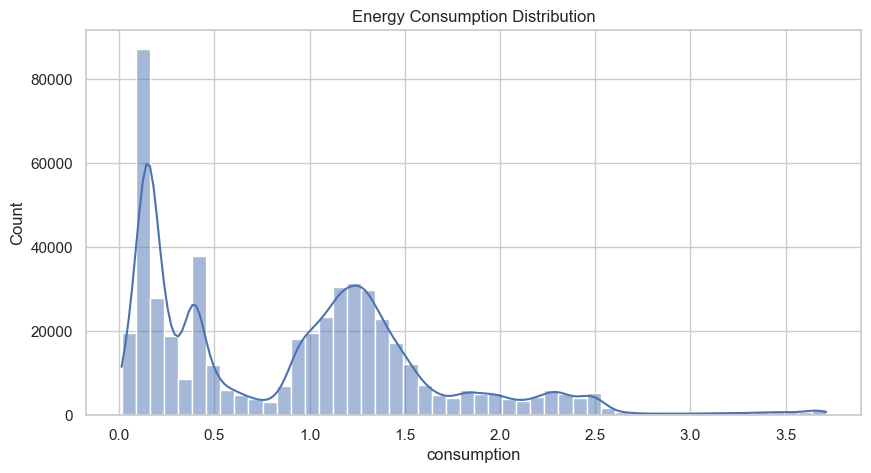

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(df_merged['consumption'], bins=50, kde=True)
plt.title('Energy Consumption Distribution')
plt.show()

### Consumption vs Temperature
Does temperature affect energy use?

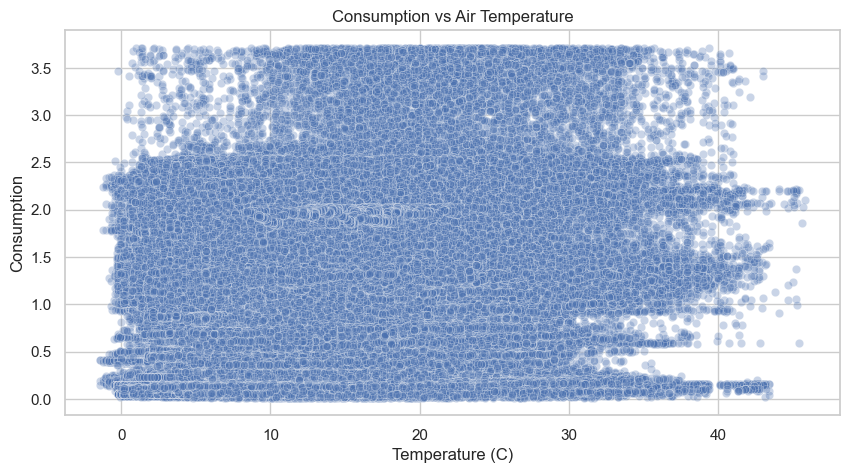

In [15]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_merged['air_temperature'], y=df_merged['consumption'], alpha=0.3)
plt.title('Consumption vs Air Temperature')
plt.xlabel('Temperature (C)')
plt.ylabel('Consumption')
plt.show()

### Consumption vs Hour
Checking usage patterns throughout the day.

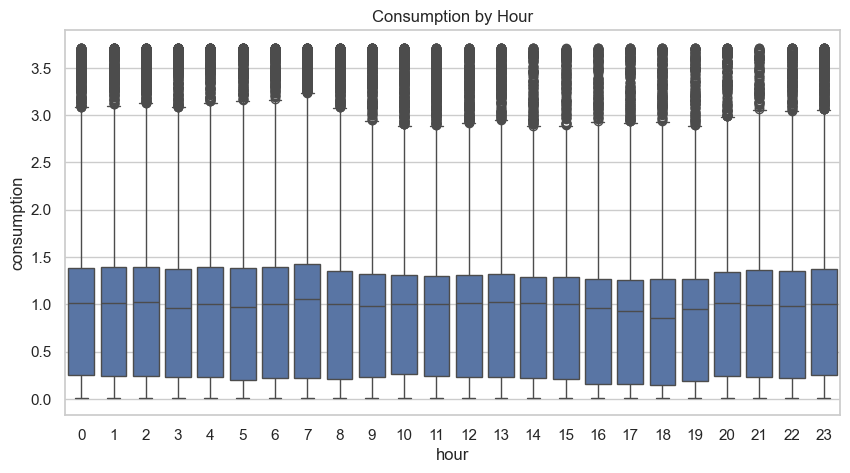

In [16]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_merged['hour'], y=df_merged['consumption'])
plt.title('Consumption by Hour')
plt.show()

### Correlation Heatmap
Seeing which features are related to each other.

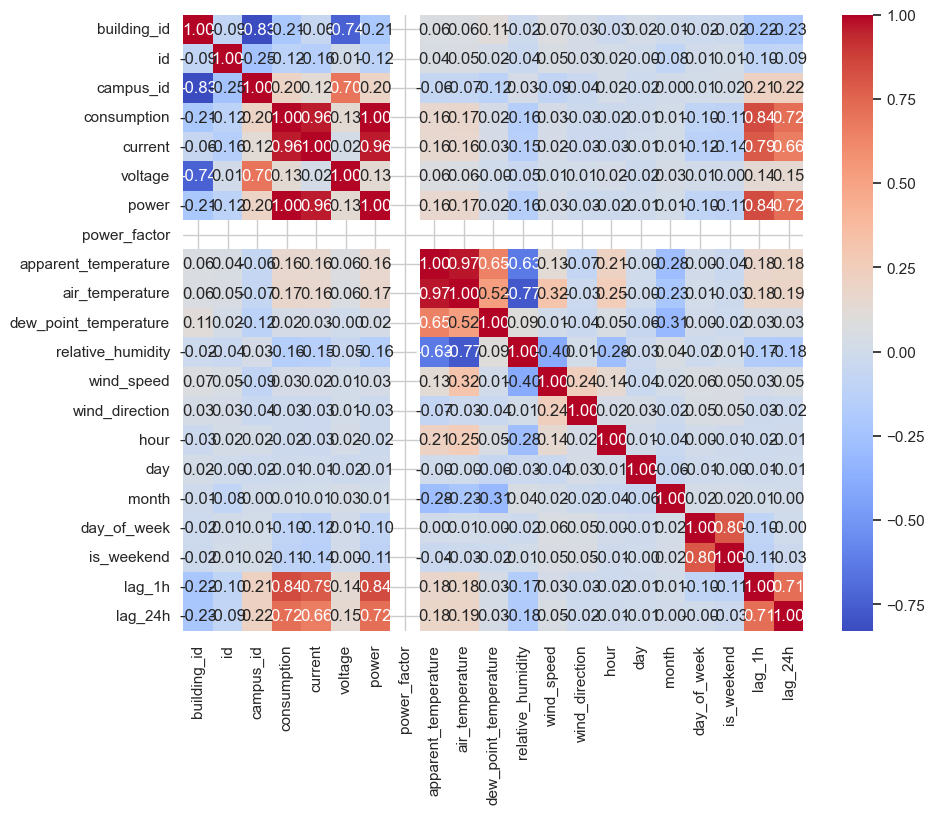

In [17]:
plt.figure(figsize=(10, 8))
numeric_cols = df_merged.select_dtypes(include=[np.number])
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### Feature Selection based on Correlation
From the heatmap, we see that `apparent_temperature` is highly correlated with `air_temperature` (> 0.95).
We will remove it to avoid multicollinearity, which can affect model performance.

In [18]:
# Dropping apparent_temperature
if 'apparent_temperature' in df_merged.columns:
    df_merged.drop(columns=['apparent_temperature'], inplace=True)
    print("Removed apparent_temperature.")

Removed apparent_temperature.


## 4. Train-Test Split

I'll select the features (X) and the target (y). I'm not using 'current' or 'voltage' because I want to predict based on weather and time.

In [19]:
from sklearn.model_selection import train_test_split

features = ['air_temperature', 'dew_point_temperature', 
            'relative_humidity', 'wind_speed', 'wind_direction', 
            'hour', 'day', 'month', 'day_of_week', 'is_weekend', 'lag_1h', 'lag_24h']

X = df_merged[features]
y = df_merged['consumption']

In [20]:
# Splitting 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features (Best practice for Linear Models)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (413492, 12)
Test shape: (103374, 12)


## 5. Model Training

I will try three different models to see which one works best.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

### Linear Regression

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

Linear Regression R2: 0.7217519293374943
Linear Regression RMSE: 0.3816029625857536


### Decision Tree

In [23]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree R2:", r2_score(y_test, y_pred_dt))
print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))

Decision Tree R2: 0.7180046456754927
Decision Tree RMSE: 0.38416397257930274


### Random Forest

In [24]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2: 0.8565172419467084
Random Forest RMSE: 0.2740283621431353


### Gradient Boosting

In [25]:
gb = HistGradientBoostingRegressor(random_state=42,verbose=10)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print("Gradient Boosting R2:", r2_score(y_test, y_pred_gb))
print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))

Binning 0.036 GB of training data: 0.085 s
Binning 0.004 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.22475, val loss: 0.22247, in 0.019s
[2/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.19425, val loss: 0.19204, in 0.015s
[3/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.16951, val loss: 0.16734, in 0.013s
[4/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.14939, val loss: 0.14725, in 0.013s
[5/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.13297, val loss: 0.13082, in 0.014s
[6/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.11963, val loss: 0.11751, in 0.014s
[7/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.10876, val loss: 0.10667, in 0.015s
[8/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.09993, val loss: 0.09786, in 0.012s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.09256, val loss: 0.09052, in 0.012s
[10/100] 1 tree, 31 leaves, max depth = 9, train lo

### XGBoost

In [26]:
xgb = XGBRegressor(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost R2:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

XGBoost R2: 0.8196121510689797
XGBoost RMSE: 0.3072552389908921


## 6. Hyperparameter Tuning

I'll use **GridSearchCV** to tune the best model. To avoid long running times, I'll use a small grid of parameters.

In [38]:
from sklearn.model_selection import GridSearchCV

# Define the model (ensure random_state is fixed for reproducibility)
rf = RandomForestRegressor(random_state=42)

# Optimized Grid
# We include the default values (100, None, 1) to ensure we don't get worse than default.
# We add 'sqrt' for max_features (faster, often better generalization).
# We add 200 trees for that extra 1% performance boost.
param_grid = {
    'n_estimators': [100, 200],        # 200 usually beats 100
    'max_depth': [None, 20],           # None is default (best for training), 20 prevents overfitting
    'min_samples_leaf': [1, 2],        # 2 helps generalization
    'max_features': [1.0, 'sqrt']      # 'sqrt' is faster and often better
}

print("Starting Grid Search... this might take a minute but is optimized.")
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, scoring='r2', verbose=1)

grid_search.fit(X_train, y_train)

Starting Grid Search... this might take a minute but is optimized.
Fitting 3 folds for each of 16 candidates, totalling 48 fits


,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [None, 20], 'max_features': [1.0, 'sqrt'], 'min_samples_leaf': [1, 2], 'n_estimators': [100, 200]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [39]:
print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
Best Score: 0.8662042089360438


In [40]:
# Training the final model with best parameters
best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)

print("Final R2:", r2_score(y_test, y_pred_final))
print("Final RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_final)))

Final R2: 0.8699893198820029
Final RMSE: 0.2608465949986113


## 7. Final Results

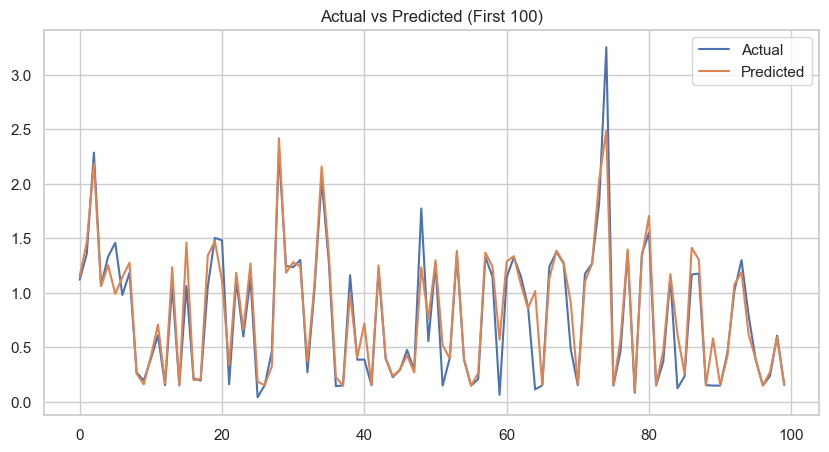

In [41]:
# Plotting Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(y_pred_final[:100], label='Predicted')
plt.legend()
plt.title('Actual vs Predicted (First 100)')
plt.show()

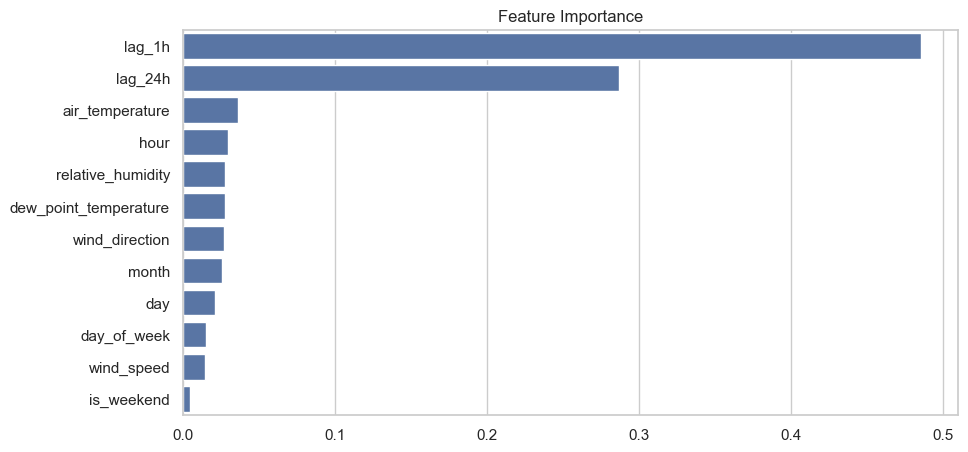

In [42]:
# Feature Importance
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=importances[indices], y=np.array(features)[indices])
    plt.title('Feature Importance')
    plt.show()
else:
    print("Feature importance not available for this model.")

## 8. Usage Classification Logic

I'll write a function to check if the current usage is High, Normal, or Low compared to the last 10 days.

In [43]:
def check_usage_status(current_val, history_df, hour):
    # Get data for the same hour
    same_hour_data = history_df[history_df['hour'] == hour]
    
    # Get last 10 records
    last_10 = same_hour_data.tail(10)
    
    if len(last_10) == 0:
        return "No data"
    
    avg_val = last_10['consumption'].mean()
    
    # Calculate limits (+/- 15%)
    high_limit = avg_val * 1.15
    low_limit = avg_val * 0.85
    
    print(f"Current: {current_val:.2f}, Average: {avg_val:.2f}")
    
    if current_val > high_limit:
        return "Usage is HIGH compared to previous days. Reduce AC or shift heavy appliances."
    elif current_val < low_limit:
        return "Usage is LOW compared to previous days."
    else:
        return "Usage is NORMAL."

In [44]:
# 1. Get the index of the test row
test_index = X_test.index[0]

# 2. Get the ORIGINAL unscaled hour from df_merged using that index
# This ensures we get an integer like 9, 10, etc., not a float like 0.215
real_test_hour = df_merged.loc[test_index]['hour']

print(f"Scaled Hour (Input to Model): {test_row['hour']}")
print(f"Real Hour (For Status Check): {real_test_hour}")

# 3. Call the function with the REAL hour
status = check_usage_status(test_val, df_merged.loc[X_train.index], real_test_hour)
print(f"Status: {status}")

Scaled Hour (Input to Model): 0.21586194334230452
Real Hour (For Status Check): 13
Current: 1.12, Average: 0.70
Status: Usage is HIGH compared to previous days. Reduce AC or shift heavy appliances.


## 9. Save Model and Scaler
Saving the trained model and scaler for use in the application.

In [45]:
import pickle
import os

# Create models directory if it doesn't exist
if not os.path.exists('../models'):
    os.makedirs('../models')

# Save the model
model_path = '../models/smart_energy_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

# Save the scaler
scaler_path = '../models/scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Model saved to {model_path}")
print(f"Scaler saved to {scaler_path}")

Model saved to ../models/smart_energy_model.pkl
Scaler saved to ../models/scaler.pkl
